In In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the tf.keras API, see this guide for details.a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### The Auto MPG dataset
The dataset is available from the UCI Machine Learning Repository.(https://archive.ics.uci.edu/ml/index.php)


#### Get the data
First download the dataset.

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/jkpark/.keras/datasets/auto-mpg.data'

In [6]:
# import it using padnas
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
row_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = row_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Clean the data
The dataset contains a few unknown values.

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
# To keep this initial tutorial simple drop those rows.
dataset = dataset.dropna()

In [9]:
# The "Origin" column is really categorical, not numeric. So convert that to a one-hot.
dataset['Origin'] = dataset['Origin'].map(lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


#### Split the data into train and test
Now split the dataset into a training set and a test set.  
We will use the test set in the final evaluation of our model.

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set.

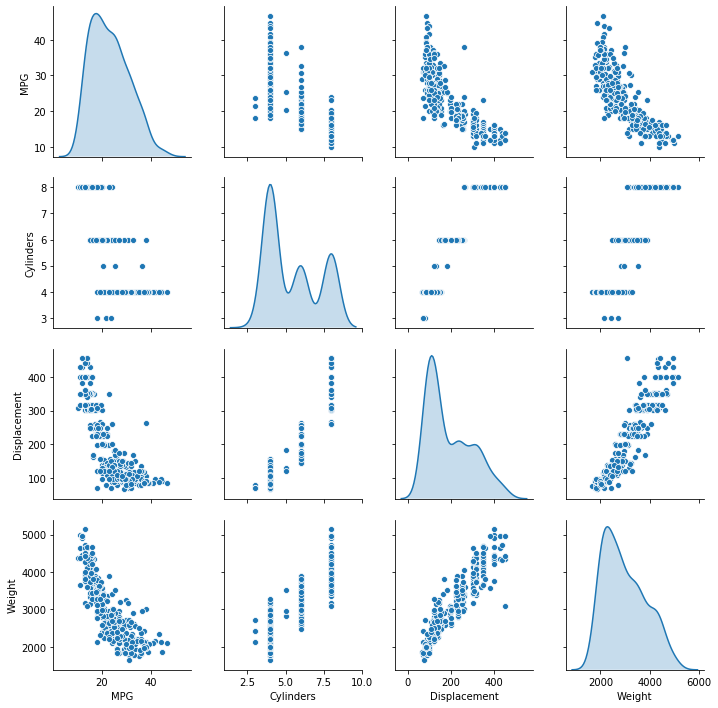

In [12]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [13]:
# Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


#### Split features from labels
Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [14]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

#### Normalize the data
Loog agin at the `train_stats` block above and note how different the ranges of each features are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [15]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

### The model
#### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that return a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [16]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [17]:
model = build_model()

#### Inspect the model
Use the `.summary` method to print a simple description of the model.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [19]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.22766285],
       [-0.14646981],
       [-0.06038833],
       [-0.28840064],
       [ 0.16940237],
       [-0.02836778],
       [ 0.17616782],
       [ 0.0015403 ],
       [-0.0723953 ],
       [ 0.40527792]])

It seems to be working, and it produces a result of the expected shape and type.

### Train the model
Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [20]:
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels,
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:562.3951,  mae:22.4608,  mse:562.3951,  val_loss:545.7842,  val_mae:22.0567,  val_mse:545.7842,  
....................................................................................................
Epoch: 100, loss:6.0939,  mae:1.7025,  mse:6.0939,  val_loss:8.8024,  val_mae:2.2074,  val_mse:8.8024,  
....................................................................................................
Epoch: 200, loss:5.3077,  mae:1.5710,  mse:5.3077,  val_loss:8.7002,  val_mae:2.2088,  val_mse:8.7002,  
....................................................................................................
Epoch: 300, loss:4.7380,  mae:1.4668,  mse:4.7380,  val_loss:9.2542,  val_mae:2.2842,  val_mse:9.2542,  
....................................................................................................
Epoch: 400, loss:4.1462,  mae:1.3869,  mse:4.1462,  val_loss:9.3077,  val_mae:2.3003,  val_mse:9.3077,  
..............................................................

In [21]:
# history.__dict__

Visualize the model's training progress using the stats stored in the `history` object.

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.253370,0.976104,2.253370,10.043608,2.387573,10.043608,995
996,2.039668,0.877243,2.039668,9.718599,2.335364,9.718599,996
997,2.106969,0.919093,2.106969,9.902855,2.376206,9.902855,997
998,2.079612,0.880193,2.079612,9.729855,2.319161,9.729855,998
999,2.065823,0.910635,2.065823,10.422301,2.439656,10.422301,999


In [23]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

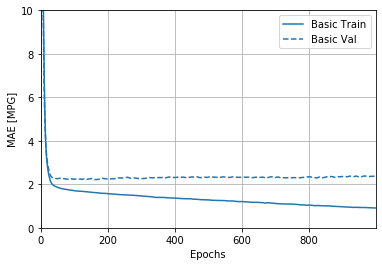

In [24]:
plotter.plot({'Basic': history}, metric = 'mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

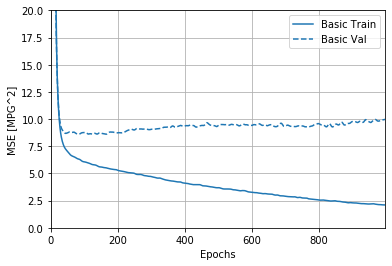

In [26]:
plotter.plot({'Basic': history}, metric = 'mse')
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an `EarlyStopping callback` that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback here.

In [27]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels,
                          epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:563.0277,  mae:22.4865,  mse:563.0277,  val_loss:550.2589,  val_mae:22.1492,  val_mse:550.2589,  
....................................................................................

Text(0, 0.5, 'MAE [MPG]')

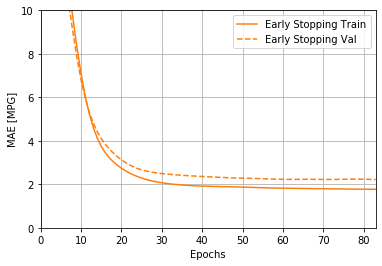

In [28]:
plotter.plot({'Early Stopping': early_history}, metric = 'mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the `test` set, which we did not use when training the model. This tells us how well we can expect the model to predict when we use it in the real world.

In [29]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.0681 - mae: 1.9761 - mse: 6.0681
Testing set Mean Abs Error:  1.98 MPG


#### Make predictions
Finally, predict MPG values using data in the testing set:

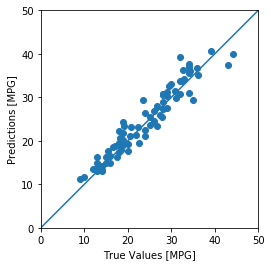

In [42]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

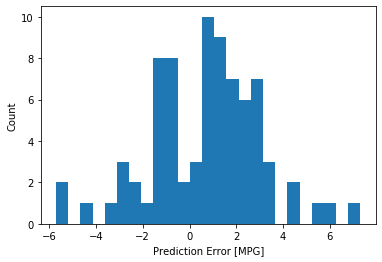

In [46]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

### Conclusion
This notebook introduced a few techniques to handle a regression problem.

- Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
- Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
- Early stopping is a useful technique to prevent overfitting.